In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import scipy
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.cm as cm
from sklearn.gaussian_process import GaussianProcessRegressor
import pickle
from tqdm import tqdm
from utils import anisotropic_kernel, get_taluk_df

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
sns.set_style("ticks")
sns.set_style("white")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

Code follows below.

In [6]:
np.random.seed(123)

In [7]:
fold_idx = 21

In [8]:
elec_data = pd.read_csv("../data/electrification.csv")

In [9]:
pearsonr(elec_data["daily_exp"], elec_data["electrification"])

(0.24690479704323848, 0.0)

In [10]:
df = pd.read_csv("../results/fold_%d/test_results.csv" % fold_idx)

In [11]:
print(df["state_name"][0])

Rajasthan


In [12]:
print("Length of original test set: %d" % len(df))

Length of original test set: 41477


In [13]:
df = df.merge(elec_data, how="inner", left_on="id", right_on="village_id")

In [14]:
df = df.loc[:,("smoothed", "true", "lat", "lng", "taluk_idx", "district_idx", "electrification", "pop")]
df = df.rename(columns={"smoothed": "pred"})

In [15]:
print("Length of merged test set: %d" % len(df))

Length of merged test set: 35293


In [16]:
print("Shape:", df.shape)

Shape: (35293, 8)


In [17]:
vmin = np.min(np.r_[df["true"], df["pred"]])
vmax = np.max(np.r_[df["true"], df["pred"]])

Text(0.5, 1.0, 'Predicted Expenditure')

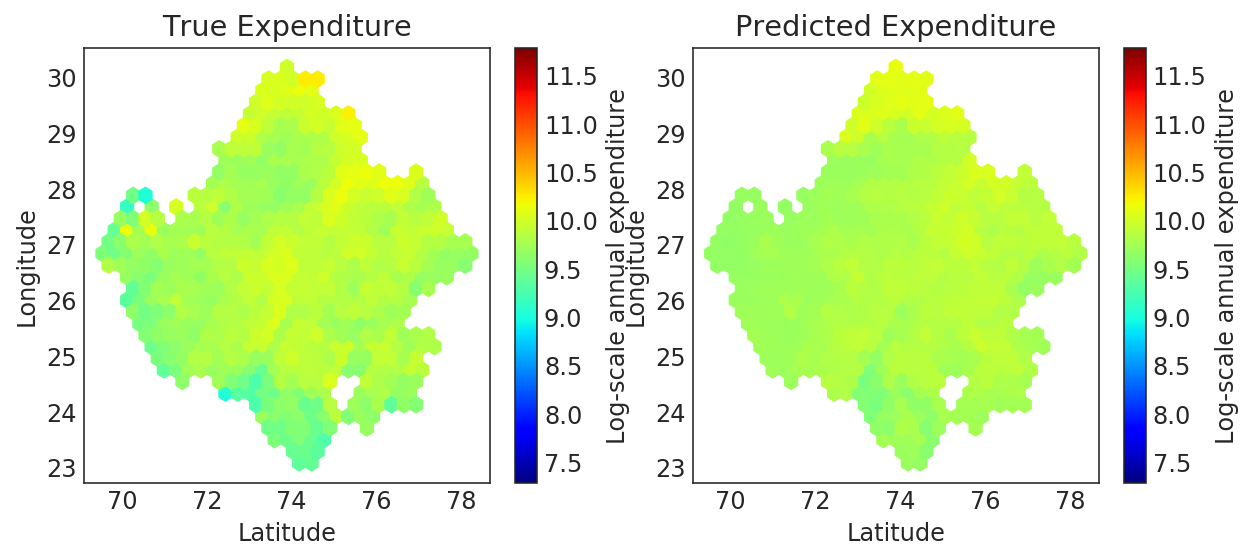

In [18]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hexbin(df["lng"], df["lat"], C=df["true"], gridsize=30, cmap=cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("True Expenditure")
plt.subplot(1,2,2)
plt.hexbin(df["lng"], df["lat"], C=df["pred"], gridsize=30, cmap=cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Predicted Expenditure")

In [19]:
scipy.stats.pearsonr(df["pred"], df["true"])

(0.526988552550905, 0.0)

#### Sampling

In [20]:
idxs = np.arange(len(df))
train_idxs = np.random.choice(idxs, int(0.5 * len(idxs)), replace=False)
val_idxs = np.array(list(set(idxs) - set(train_idxs)))

In [21]:
df_train = df.iloc[train_idxs,:]
df_val = df.iloc[val_idxs,:]

In [22]:
len(df_train), len(df_val)

(17646, 17647)

Text(0, 0.5, 'Latitude')

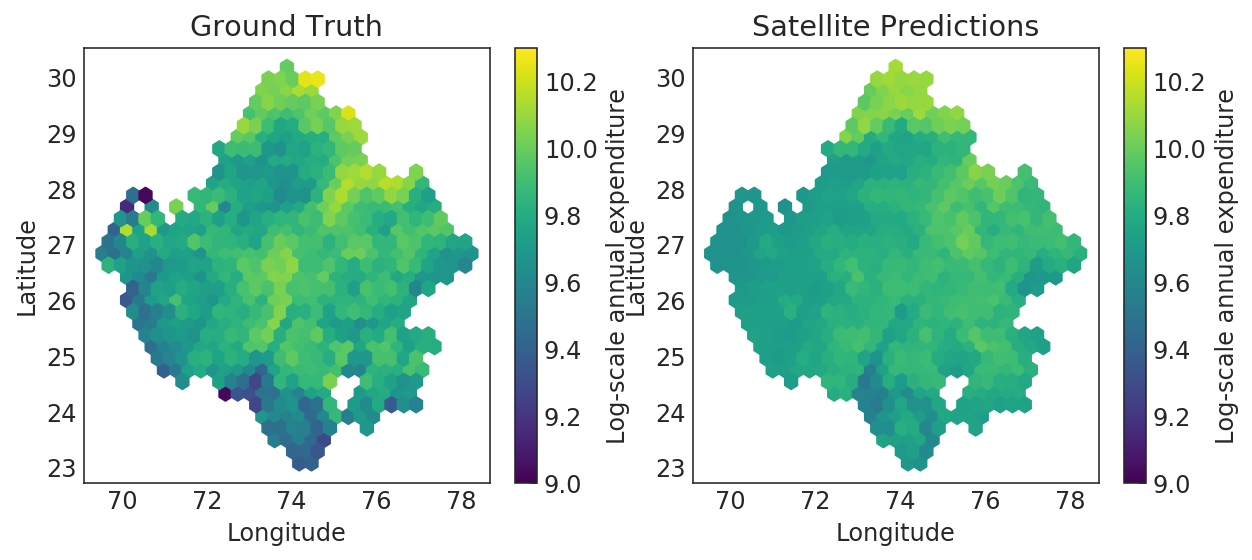

In [134]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
hb = plt.hexbin(df["lng"], df["lat"], gridsize=30, C=df["true"], cmap=cm.viridis, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Ground Truth")
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.subplot(1,2,2)
hb = plt.hexbin(df["lng"], df["lat"], gridsize=30, C=df["pred"], cmap=cm.viridis, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Satellite Predictions")
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [34]:
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF

In [76]:
idxs = np.arange(len(df))
np.random.shuffle(idxs)

In [149]:
n = 100

In [150]:
df_sampled = df.iloc[df.index.isin(idxs[:n]),:] 

In [151]:
curr_kernel = RBF() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=curr_kernel, normalize_y=True)
gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [152]:
preds, std = gp.predict(df.loc[:,("lat", "lng")], return_std = 1)

In [153]:
vmin = np.min(np.r_[df["true"], df["pred"]])
vmax = np.max(np.r_[df["true"], df["pred"]])

In [154]:
vmin = 9
vmax = 10.3

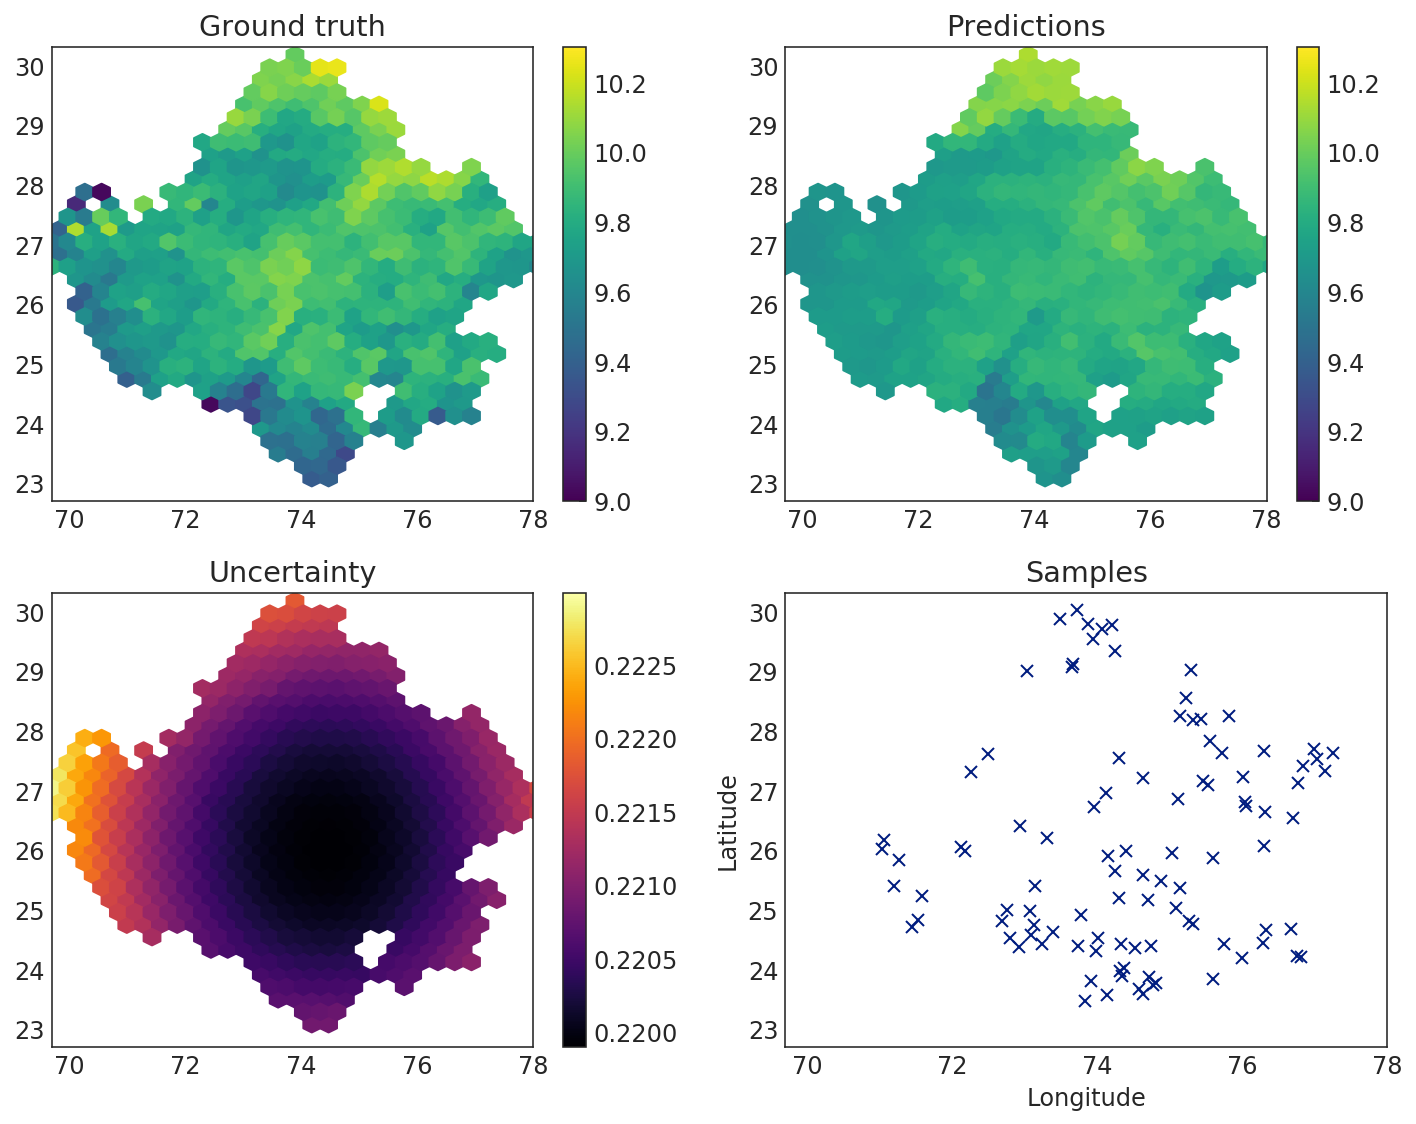

In [157]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
hb = plt.hexbin(df["lng"], df["lat"], gridsize=30, C=df["true"], cmap = cm.viridis, vmin = vmin, vmax=vmax)
cb = plt.colorbar()
plt.title("Ground truth")
plt.xlim((69.7, 78))
plt.ylim((22.7, 30.3))

plt.subplot(2,2,2)
hb = plt.hexbin(df["lng"], df["lat"], gridsize=30, C=preds + df["pred"], 
                cmap=cm.viridis, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Predictions")
plt.xlim((69.7, 78))
plt.ylim((22.7, 30.3))

plt.subplot(2,2,3)
hb = plt.hexbin(df["lng"], df["lat"], gridsize=30, C=std, 
                cmap=cm.inferno)
plt.title("Uncertainty")
cb = plt.colorbar()
plt.xlim((69.7, 78))
plt.ylim((22.7, 30.3))


plt.subplot(2,2,4)
hb = plt.plot(df_sampled["lng"], df_sampled["lat"], "x")
plt.title("Samples")
plt.xlim((69.7, 78))
plt.ylim((22.7, 30.3))

#cb.set_label("Log-scale annual expenditure")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

#### Coefficient Estimation

In [28]:
from utils import *

In [29]:
anisotropic_kernel = SubspaceRBF(dims=np.array([0,1]),
                                 length_scale_bounds=(1e-3, 1e3)) + \
                     SubspaceDot(dims=np.array([2])) + WhiteKernel()

In [30]:
print(len(df))

35293


In [107]:
idxs = list(np.random.choice(len(df), 500))
df_sampled = df.iloc[df.index.isin(idxs),:]

In [108]:
curr_kernel = SubspaceRBF([0,1]) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=curr_kernel, normalize_y=True)
gp.fit(df_sampled.loc[:,("lat", "lng", "pred")], df_sampled["true"] - df_sampled["pred"])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=SubspaceRBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [109]:
print(gp.kernel_)

SubspaceRBF(length_scale=4.09) + WhiteKernel(noise_level=0.0482)


In [110]:
# SubspaceRBF(length_scale=9.54) + SubspaceDot(sigma_0=10.6) + WhiteKernel(noise_level=0.0547)
#tuned_kernel = SubspaceRBF(dims = [0,1], length_scale=4.12) + SubspaceDot(dims = [2], sigma_0=9.95) + WhiteKernel(noise_level=0.0424)

In [77]:
# tuned_kernel = SubspaceRBF(dims = [0,1], length_scale=4.12) + \
#   SubspaceDot(dims = [2], sigma_0=9.95) + \
#   WhiteKernel(noise_level=0.0424)

In [78]:
# gp = GaussianProcessRegressor(kernel=tuned_kernel, normalize_y=True, optimizer=None)
# gp.fit(df_sampled.loc[:,("lat", "lng", "pred")], df_sampled["true"])
# gp._K_inv = None

In [79]:
mean, pred_std = gp.predict(df.loc[:, ("lat", "lng", "pred")], return_std=True)

In [80]:
pred_std

array([0.21704773, 0.21709995, 0.21533605, ..., 0.21585349, 0.21677649,
       0.2155654 ])

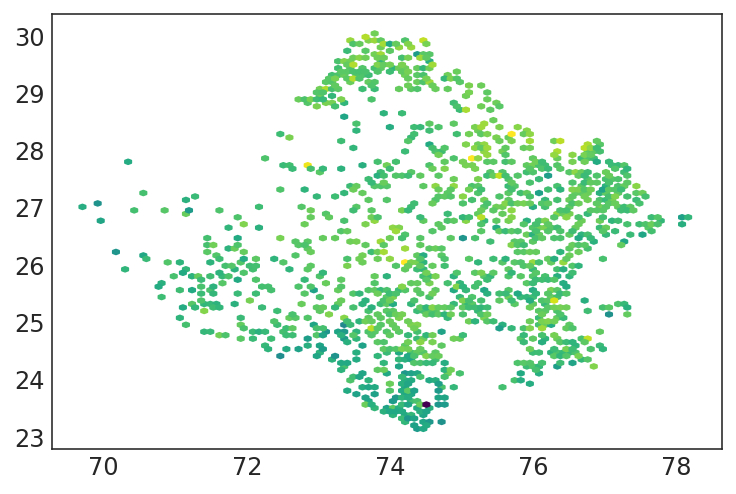

In [81]:
plt.hexbin(df_sampled["lng"], df_sampled["lat"], C = df_sampled["true"], cmap = cm.viridis)

In [82]:
vmin = np.min(np.r_[df["true"], mean])
vmax = np.max(np.r_[df["true"], mean])

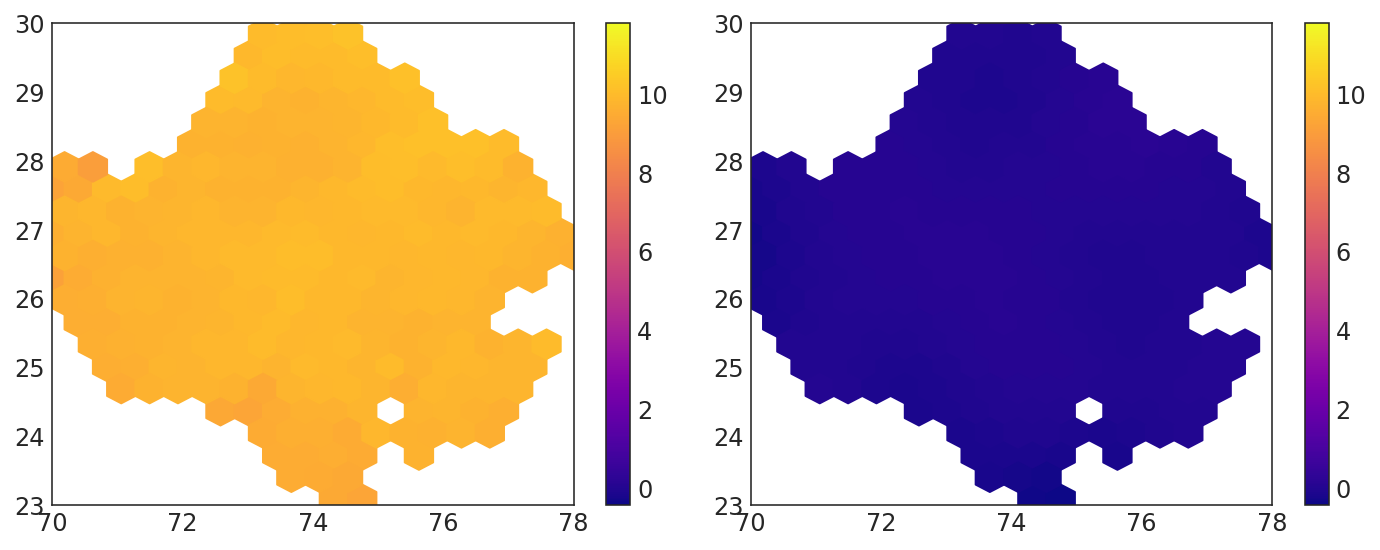

In [83]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hexbin(df["lng"], df["lat"], gridsize=20, 
           C=df["true"], cmap=cm.plasma, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.xlim((70, 78))
plt.ylim((23, 30))
plt.subplot(1,2,2)
hb = plt.hexbin(df["lng"], df["lat"], gridsize=20, 
                C=mean,  cmap=cm.plasma, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.xlim((70, 78))
plt.ylim((23, 30))
plt.tight_layout()

In [84]:
r2_score(df["true"], mean + df["pred"])

0.34983774226225106

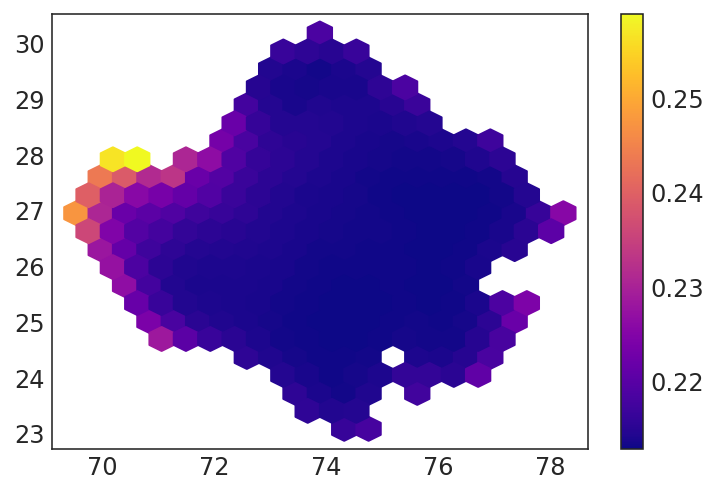

In [85]:
hb = plt.hexbin(df["lng"], df["lat"], gridsize=20, 
                C=pred_std,  cmap=cm.plasma)
plt.colorbar()